# Sistema de Recomendación - Oferta Formativa de SIFODS
Autor : Junior T. Ortiz Mejia <br>
Fecha : Mayo , 2023

## Origen de Datos

In [972]:
# Librerias a usar 
import pandas as pd 
import numpy as np
import scipy
import pyodbc
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix



import warnings
warnings.filterwarnings('ignore')


In [973]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [974]:
#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT A.ID, 
		A.NOMBRE, 
		A.PROPOSITO,
		A.PUBLICO_OBJETIVO,
		B.DESCRIPCION AS TIPO_OFERTA_FORMATIVA,
		C.DESCRIPCION AS AREA_EDUCATIVA,
		D.DESCRIPCION AS NVEL_EDUCATIVO, 
		E.DESCRIPCION AS MODALIDAD_EDUCATIVA
	FROM [st].[SI_acfm.maestro.oferta_formativa] A
	LEFT JOIN [st].[SI_dbo.maestro.parametros] B ON A.TIPO_OFERTA_FORMATIVA = B.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] C ON A.AREA_EDUCATIVA = C.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] D ON A.NIVEL_EDUCATIVO = D.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] E ON A.MODALIDAD_EDUCATIVA = E.ID
	WHERE A.ACTIVO = '1' AND B.DESCRIPCION = 'Curso'"""
    
oferta_formativa_df = pd.read_sql_query(query1,conn)


## interacciones del usuario con sifods
query2 = """SELECT ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS FROM st.[SI_acfm.transaccional.oferta_formativa_accion]"""
acciones_df = pd.read_sql_query(query2,conn)

## Participantes en los cursos de la oferta formativa
query3 = """SELECT A.ID_OFERTA_FORMATIVA,B.USUARIO_DOCUMENTO
				FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante_ultimo] A
				INNER JOIN [st].[SI_acfm.transaccional.oferta_formativa_participante] B on A.ID_PARTICIPANTE=B.ID_PARTICIPANTE
				WHERE A.CUMPLIMIENTO_ACTIVIDAD = 'COMPLETARON'"""
curso_participante_df = pd.read_sql_query(query3,conn)


#Cerrar la conexion
conn.close()

**Data Frame extraidos**

In [975]:
oferta_formativa_df.head(3)

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,114,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO PR...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Todas,None,EBR
1,122,APRENDIZAJE A NIVEL REAL COMUNICACIÓN,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Comunicación,None,EBR
2,116,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CO...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Comunicación,None,EBR


In [976]:
acciones_df.head(3)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS
0,78,06680611,False,5,0,0,0,0
1,34,02286006,False,1,0,0,0,0
2,79,99999999,False,6,0,0,0,0


In [978]:
curso_participante_df.head(3)

,ID_OFERTA_FORMATIVA,USUARIO_DOCUMENTO
0,236,19531279
1,238,41871950
2,239,45345009


## Manipulación de datos

**Maestro oferta formativa**

In [979]:
#Conversion a mayusculas en nombre el df de la oferta formativa
oferta_formativa_df = oferta_formativa_df.apply(lambda x: x.astype("str").str.upper())

In [980]:
oferta_formativa_df.head(3)

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,114,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO PR...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,TODAS,NONE,EBR
1,122,APRENDIZAJE A NIVEL REAL COMUNICACIÓN,FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,COMUNICACIÓN,NONE,EBR
2,116,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CO...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,COMUNICACIÓN,NONE,EBR


<b> Transaccional oferta formativa acción <b>

In [982]:
#Evidencia de valores duplicados
dup_acciones_df = acciones_df.groupby(['ID_OFERTA_FORMATIVA','DNI_DOCENTE'])['DNI_DOCENTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_acciones_df[dup_acciones_df['CONTEO']>1]

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,CONTEO
0,196,23949889,2
1,243,29537963,2
2,235,43361220,2
3,196,45999263,2
4,235,20031202,2
...,...,...,...
1412,244,08687644,2
1413,237,43767375,2
1414,243,42127430,2
1415,250,44336438,2


In [983]:
#Reduccion de ocurrencias de ID_OFERTA_FORMATIVA, DNI_DOCENTE
acciones_df = acciones_df.drop_duplicates(['ID_OFERTA_FORMATIVA','DNI_DOCENTE'],keep='last')
acciones_df.shape

(261913, 8)

In [984]:
#Cruce de datos con los oferta formativa tipo cursos
acciones_df['ID_OFERTA_FORMATIVA'] = acciones_df['ID_OFERTA_FORMATIVA'].astype('str')
acciones_df_validos = oferta_formativa_df.merge(acciones_df , how='left',left_on='ID',right_on='ID_OFERTA_FORMATIVA')
print('El dataframe acciones tiene %d registros' % acciones_df_validos.shape[0])

El dataframe acciones tiene 151412 registros


**Transaccional oferta formatva curso participante**

Para esta tabla se vio por conveniente realizar un script de sql para poder optimizar la transacción

In [985]:
#Verificar la tabla
curso_participante_df.head(3)

,ID_OFERTA_FORMATIVA,USUARIO_DOCUMENTO
0,236,19531279
1,238,41871950
2,239,45345009


# Análisis Descriptivo Estadístico

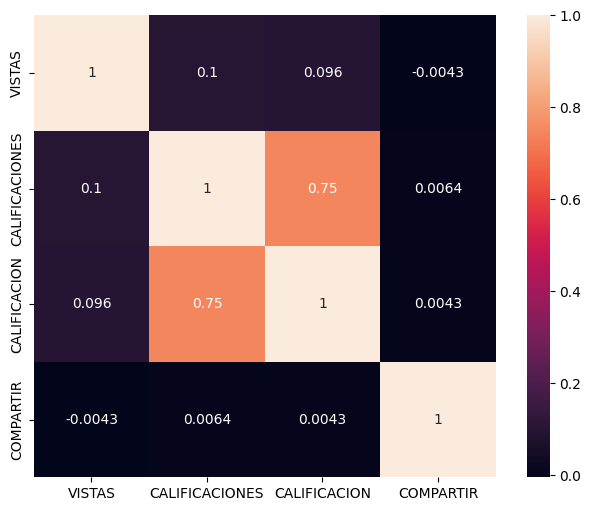

In [986]:
correlacion = acciones_df[['VISTAS','CALIFICACIONES','CALIFICACION','COMPARTIR']]
#Correlacion de Pearson 
plt.subplots(figsize=(8, 6))
sns.heatmap(correlacion.corr(), annot=True, square=True)
plt.show()


<Axes: ylabel='Density'>

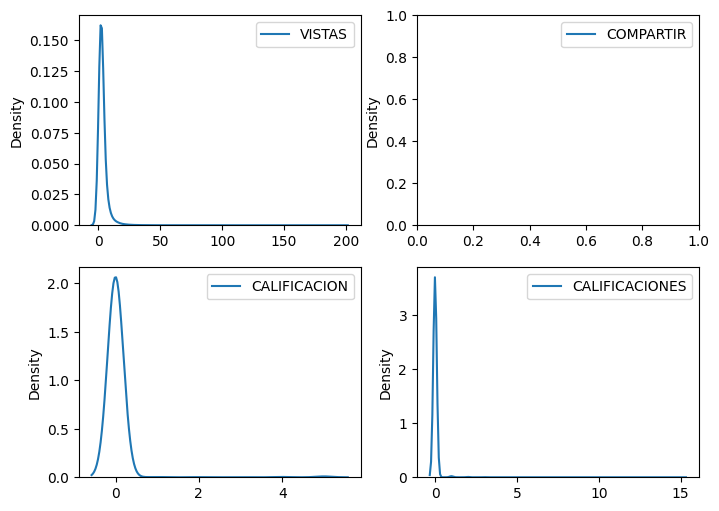

In [987]:
#Grafico de densidad de la variables de interracion 
f, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.kdeplot(acciones_df_validos[["VISTAS"]], bw=0.5, ax=axes[0,0])
sns.kdeplot(acciones_df_validos[["CALIFICACION"]], bw=0.5, ax=axes[1,0])
sns.kdeplot(acciones_df_validos[["COMPARTIR"]], bw=0.5, ax=axes[0,1])
sns.kdeplot(acciones_df_validos[["CALIFICACIONES"]], bw=0.5, ax=axes[1,1])

In [988]:
#Cursos mas populares
rating_oferta_formativa = acciones_df_validos[['ID_OFERTA_FORMATIVA', 'VISTAS']].groupby('ID_OFERTA_FORMATIVA').mean().reset_index().sort_values('VISTAS', ascending=False)
rating_oferta_formativa['ID_OFERTA_FORMATIVA'] = rating_oferta_formativa['ID_OFERTA_FORMATIVA'].astype('str')

rating_oferta_formativa_df = rating_oferta_formativa.merge(oferta_formativa_df, how='left',left_on='ID_OFERTA_FORMATIVA',right_on='ID')
rating_oferta_formativa_df[['NOMBRE','VISTAS']].head(5)

,NOMBRE,VISTAS
0,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,5.063342
1,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,4.120055
2,ENSEÑAR AL NIVEL REAL DE LOS APRENDIZAJES I CO...,4.000000
3,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,3.956456
4,LA LECTURA Y LA ESCRITURA EN LOS PRIMEROS AÑOS...,3.891933


In [989]:
#Frecuencia de cursos mas populares
frecuencia_cursos = acciones_df_validos['ID_OFERTA_FORMATIVA'].value_counts()
# Frecuencia de curso con mas de 100 interacciones
frecuencia_valida_cursos = frecuencia_cursos[frecuencia_cursos > 100].index

In [990]:
#Tomamos como referencia solo los cursos con frecuencia mas de 100
acciones_df_100 = acciones_df_validos[acciones_df_validos['ID_OFERTA_FORMATIVA'].isin(frecuencia_valida_cursos)]
rating_oferta_formativa_100 = acciones_df_100[['ID_OFERTA_FORMATIVA', 'VISTAS']].groupby('ID_OFERTA_FORMATIVA').mean().reset_index().sort_values('VISTAS', ascending=False)
#rating_oferta_formativa_100['ID_OFERTA_FORMATIVA'] = rating_oferta_formativa_100['ID_OFERTA_FORMATIVA'].astype('int64')
rating_oferta_formativa_df_100 = rating_oferta_formativa_100.merge(oferta_formativa_df, how='left', left_on='ID_OFERTA_FORMATIVA', right_on='ID')
#rating de cursos con promedio de vistas e interracciones mayores a 100
rating_oferta_formativa_df_100[['ID','NOMBRE', 'VISTAS']].head(5)

,ID,NOMBRE,VISTAS
0,232,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,5.063342
1,205,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,4.120055
2,231,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,3.956456
3,249,LA LECTURA Y LA ESCRITURA EN LOS PRIMEROS AÑOS...,3.891933
4,250,COMPETENCIAS MATEMÁTICAS EN LOS PRIMEROS AÑOS ...,3.853269


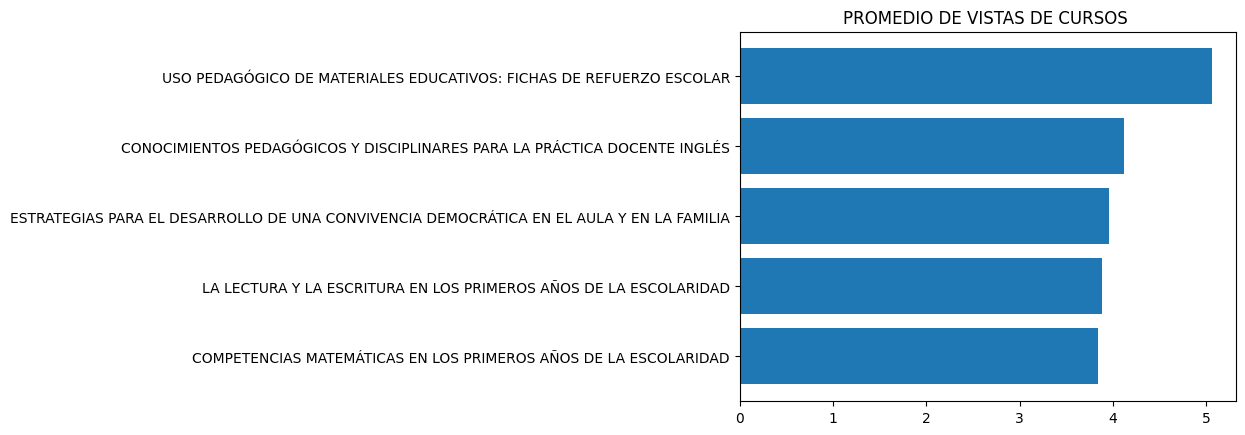

In [18]:
#grafico de promedio de vistas de los cursos e interraciones mayores a 100 top 5
rating_oferta_formativa_top5 = rating_oferta_formativa_df_100.head(5).sort_values('VISTAS',ascending=True)
plt.barh('NOMBRE', 'VISTAS', data=rating_oferta_formativa_top5)
plt.title("PROMEDIO DE VISTAS DE CURSOS ")
plt.show()

# Selección de Variables
Se reviso las columnas de:
- Preferencia : Indica un "me gusta" en el curso
- Vistas : Contador de ingresos a los cursos
- Calificaciones : Numero de calificaciones que se da aun curso 
- Calificación : Puntuacion que se le asigna a un curso (las estrellas de que van de 0 a 5 )
- Compartir : Contador de la opcion compartir ( se puede compartir por facebook,linkedin, whatsapp, pinterest y twiter )
- Comentarios : Comentarios sobre el curso 

Los sistemas de recomendación se enfrentan al problema conocido como "arranque en frio", en el que es dificil proporcionar recomendaciones personalizadas a usuarios que no han consumido nada o muy poco
por ese motivo se excluiran a las personas con 0 vistas y con acciones en un solo curso

In [991]:
#Preferencia 
Porcentaje_preferencia=round((len(acciones_df_validos[acciones_df_validos['PREFERENCIA'] == 1]) / len(acciones_df_validos) )* 100,1)
Porcentaje_vistas = round((len(acciones_df_validos[acciones_df_validos['VISTAS'] > 1]) / len(acciones_df_validos)) * 100,1)
Porcentaje_calificaciones = round((len(acciones_df_validos[acciones_df_validos['CALIFICACIONES'] > 1]) / len(acciones_df_validos)) * 100,1)
Porcentaje_califacion = round((len(acciones_df_validos[acciones_df_validos['CALIFICACION'] >0 ]) / len(acciones_df_validos)) * 100,1)
Porcentaje_compartir = round((len(acciones_df_validos[acciones_df_validos['COMPARTIR'] >0 ]) / len(acciones_df_validos)) * 100,1)
Porcentaje_comentarios = round((len(acciones_df_validos[acciones_df_validos['COMENTARIOS'] >0 ]) / len(acciones_df_validos)) * 100,1)

print('Porcentaje de datos en la variable PREFERENCIA : ' + str(Porcentaje_preferencia) + '%')
print('Porcentaje de datos en la variable VISTAS : ' + str(Porcentaje_vistas) + '%')
print('Porcentaje de datos en la variable CALIFICACIONES : ' + str(Porcentaje_calificaciones) + '%')
print('Porcentaje de datos en la variable CALIFICACION : ' + str(Porcentaje_califacion) + '%')
print('Porcentaje de datos en la variable COMPARTIR : ' + str(Porcentaje_compartir) + '%')
print('Porcentaje de datos en la variable COMENTARIOS : ' + str(Porcentaje_comentarios) + '%')

Porcentaje de datos en la variable PREFERENCIA : 3.0%
Porcentaje de datos en la variable VISTAS : 83.9%
Porcentaje de datos en la variable CALIFICACIONES : 0.3%
Porcentaje de datos en la variable CALIFICACION : 0.9%
Porcentaje de datos en la variable COMPARTIR : 0.0%
Porcentaje de datos en la variable COMENTARIOS : 0.0%


In [992]:
#Exclusion  de valores con vistas 0
acciones_df_validos = acciones_df_validos[acciones_df_validos['VISTAS']>0]

In [993]:
usuario_interaccion_count = acciones_df_validos.groupby(['DNI_DOCENTE', 'ID_OFERTA_FORMATIVA']).size().groupby('DNI_DOCENTE').size()
print('# usuarios: %d' % len(usuario_interaccion_count))
usuario_considerado = usuario_interaccion_count[usuario_interaccion_count >= 2].index
print('# usuarios con mas de 2 acciones:  %d' % len(usuario_considerado)) 

# usuarios: 69299
# usuarios con mas de 2 acciones:  31813


In [994]:
print('# de acciones :  %d' % len(acciones_df_validos))
acciones_seleccionadas = acciones_df_validos[acciones_df_validos['DNI_DOCENTE'].isin(usuario_considerado)]
print('# de acciones de usuarios seleccionados : %d' %len(acciones_seleccionadas))

# de acciones :  150670
# de acciones de usuarios seleccionados : 113184


In [1003]:
#Seleccionamos  las columnas de interes del dataframe acciones_seleccionadas
acciones_full_df=acciones_seleccionadas[['ID_OFERTA_FORMATIVA','DNI_DOCENTE','VISTAS']]
acciones_full_df

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS
1,114,33429607,1.0
2,114,70321563,1.0
4,114,10234267,1.0
5,114,48628110,2.0
6,114,19669484,2.0
...,...,...,...
151406,234,01127982,4.0
151407,234,02794556,2.0
151408,234,74251168,4.0
151410,234,42512443,2.0


In [1004]:
acciones_full_df['PUNTAJE'] = pd.qcut(acciones_full_df['VISTAS'], q=5, labels=False,duplicates='drop') + 1

In [1005]:
acciones_full_df.head(5)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS,PUNTAJE
1,114,33429607,1.0,1
2,114,70321563,1.0,1
4,114,10234267,1.0,1
5,114,48628110,2.0,1
6,114,19669484,2.0,1


In [1006]:
acciones_full_df.PUNTAJE.value_counts()

PUNTAJE
1    60102
2    20499
3    16593
4    15990
Name: count, dtype: int64

In [1007]:
acciones_full_df = acciones_full_df.drop(["VISTAS"],axis=1)

# Evaluacion

Se utiliza el método de validación cruzada denominada hold out en el que una muestra aleatoria de datos se mantiene al margen del proceso de entrenamiento y se utiliza exclusivamente para la evaluación

In [1008]:
acciones_df_entrenamiento, acciones_df_prueba = train_test_split(acciones_full_df,stratify=acciones_full_df['DNI_DOCENTE'],test_size=0.3,random_state=29)

print("# de acciones en el dataset entrenamiento %d " %len(acciones_df_entrenamiento))
print("# de acciones en el dataset prueba %d" %len(acciones_df_prueba))

# de acciones en el dataset entrenamiento 79228 
# de acciones en el dataset prueba 33956


In [1009]:
#indexación del DNI_Docente
acciones_df_indexed = acciones_full_df.set_index('DNI_DOCENTE')
acciones_df_entrenamiento_indexed = acciones_df_entrenamiento.set_index('DNI_DOCENTE')
acciones_df_prueba_indexed = acciones_df_prueba.set_index('DNI_DOCENTE')

In [1010]:
def obtener_items_interactuados(dni, acciones_full_df):
    #Obtener los datos del usuario y fusionar la información 
    acciones_cursos = acciones_full_df.loc[dni]['ID_OFERTA_FORMATIVA']
    return set(acciones_cursos if type(acciones_cursos) == pd.Series else [acciones_cursos])

In [1011]:
# Metricas de precisión TOP-N 
EVALUADOR_ALEATORIO_MUESTREO_NO_ACCIONES_ITEMS = 50

class EvaluacionModelo :

    def obtener_muestra_elementos_no_interactuados(self, dni, tamaño_muestra, seed=42):
        acciones_items = obtener_items_interactuados(dni, acciones_df_indexed)
        todos_items = set(oferta_formativa_df['ID'])
        items_no_interaccion = todos_items - acciones_items

        random.seed(seed)
        items_no_interacciones_muestra = random.sample( items_no_interaccion, tamaño_muestra)
        return set(items_no_interacciones_muestra)

    def _verificar_acierto_top_n(self, item_id, recomendador_oferta, topn) :
        try:
            index = next(i for i, c in enumerate(recomendador_oferta) if c == item_id)
        except :
            index = -1 
        acierto = int(index in range(0, topn))
        return acierto, index

    def evaluar_modelo_para_usuario(self, modelo, dni):
        #Obtener los elemntos del conjunto de prueba
        valores_acciones_prueba = acciones_df_prueba_indexed .loc[dni]
        if type(valores_acciones_prueba['ID_OFERTA_FORMATIVA']) == pd.Series:elementos_interactuados_por_persona = set(
            valores_acciones_prueba['ID_OFERTA_FORMATIVA'])
        else:
            elementos_interactuados_por_persona = set([int(valores_acciones_prueba['ID_OFERTA_FORMATIVA'])])
        contador_valores_acciones_prueba = len(elementos_interactuados_por_persona)

        #Obtención de una lista de recomendaciones clasificadas a partir de un modelo para un usuario determinado
        person_recs_df = modelo.recommend_items(dni, items_para_ignorar=obtener_items_interactuados(dni, acciones_df_entrenamiento_indexed ), topn=50)

        acierto_para_5_contador = 0
        acierto_para_10_contador = 0
        #Para cada elementos con el que el usuario ha interactuado en el conjunto de pruebas
        for item_id in elementos_interactuados_por_persona : 
            #Obtención de una muestra aleatoria (100) de elementos con los que el usuario no ha interactuado 
            #Para presentar elementos que se supone que no son relevantes para el usuario
            items_no_interacciones_muestra = self.obtener_muestra_elementos_no_interactuados(dni,
                                                                                                tamaño_muestra=EVALUADOR_ALEATORIO_MUESTREO_NO_ACCIONES_ITEMS,
                                                                                                seed = item_id)

            #Combinar el elemento interactuado actual con los 100 elementos aleatorios
            elementos_para_filtrar_recs = items_no_interacciones_muestra.union(set([item_id]))

            #Filtrar sólo las recomendaciones que son el elemento recomendado o de una muestra aleatoria de 100 elementos no interactuados
            valido_recs_df = person_recs_df[person_recs_df['ID_OFERTA_FORMATIVA'].isin(elementos_para_filtrar_recs)]
            valido_recs = valido_recs_df['ID_OFERTA_FORMATIVA'].values
            #Comprobacion de si el elemento interactuado se encuentra entre los N primeros elementos recomendados
            acierto_para_5, indice_para_5 = self._verificar_acierto_top_n(item_id, valido_recs, 5)
            acierto_para_5_contador += acierto_para_5
            acierto_para_10, indice_para_10 = self._verificar_acierto_top_n(item_id,valido_recs, 10)
            acierto_para_10_contador += indice_para_10

        #Recall es el porcentaje de elementos interactuado que se clasifican entre los N elementos recomendados
        #cuando se mezcla con un conjunto de datos no pertinentes
        recall_para_5 = acierto_para_5_contador / float(contador_valores_acciones_prueba)
        recall_para_10 = acierto_para_10_contador / float(contador_valores_acciones_prueba)

        metricas_persona =  { 'aciertos@5':acierto_para_5_contador,
                                'aciertos@10':acierto_para_10_contador,
                                'acciones_count': contador_valores_acciones_prueba,
                                'recall@5' : recall_para_5,
                                'recall@10' : recall_para_10}
        return metricas_persona



    def evaluar_modelo(self, modelo):
        personas_metricas = []
        for idx , dni in enumerate(list(acciones_df_prueba_indexed.index.unique().values)):
            # si idx % 100 == 0 and idx > 0:
            # print('%d users processed' % idx)
            metricas_persona = self.evaluar_modelo_para_usuario(modelo, dni)
            metricas_persona['DNI_DOCUMENTO'] = dni
            personas_metricas.append(metricas_persona)
        print('%d usuarios procesados' % idx)

        resultados_detallados_df = pd.DataFrame(personas_metricas)\
                                        .sort_values('acciones_count',ascending=False)

        global_recall_para_5 = resultados_detallados_df['aciertos@5'].sum() / float(resultados_detallados_df['acciones_count'].sum())
        global_recall_para_10 = resultados_detallados_df['aciertos@10'].sum() / float(resultados_detallados_df['acciones_count'].sum())

        metricas_globales = {'Modelo': modelo.get_model_name(),
                        'recall@5': global_recall_para_5,
                        'recall@10': global_recall_para_10}
        return metricas_globales, resultados_detallados_df

evaluador_modelo = EvaluacionModelo()

## MODELO POPULAR

Un modelo habitual es el modelo de popularidad. este modelo no es personalizado, sino que se limita a recomendar a un usuario los articulos más populares que haya consumido anteriormente

In [1012]:
#Calcular los curso mas populares de la oferta formativa
curso_popular_df = acciones_full_df.groupby('ID_OFERTA_FORMATIVA')['PUNTAJE'].sum().sort_values(ascending=False).reset_index()
curso_popular_df['ID_OFERTA_FORMATIVA'] = curso_popular_df['ID_OFERTA_FORMATIVA'].astype('int64')
curso_popular_df

,ID_OFERTA_FORMATIVA,PUNTAJE
0,232,25982
1,231,18021
2,197,16200
3,196,13762
4,208,8207
...,...,...
91,280,1
92,281,1
93,291,1
94,246,1


In [1013]:
class RecomendadorPopular:

    MODEL_NAME = 'Popularidad'

    def __init__(self, popularidad_df, items_df=None):
        self.popularidad_df = popularidad_df
        self.items_df = items_df

    def get_model_name(self) :
        return self.MODEL_NAME

    def recommend_items(self, DNI_DOCENTE, items_para_ignorar=[], topn=10, verbose=False):
        # Recomienda los cursos más populares que el usuario no ha calificado
        recomendaciones_df = self.popularidad_df[~self.popularidad_df['ID_OFERTA_FORMATIVA'].isin(items_para_ignorar)] \
                                                                .sort_values('PUNTAJE', ascending = False) \
                                                                .head(topn)
        if verbose :
            if self.items_df is None :
                raise Exception(' "items_df" is required in verbose mode')

            recomendaciones_df = recomendaciones_df.merge(self.items_df, how='left',
                                                            left_on='ID_OFERTA_FORMATIVA',
                                                            right_on = 'ID_OFERTA_FORMATIVA')

        return recomendaciones_df


modelo_popularidad = RecomendadorPopular(curso_popular_df, oferta_formativa_df)


In [1014]:
curso_popular_df['ID_OFERTA_FORMATIVA'] = curso_popular_df['ID_OFERTA_FORMATIVA'].astype("str")

In [1015]:
curso_popular_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_OFERTA_FORMATIVA  96 non-null     object
 1   PUNTAJE              96 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [1016]:
oferta_formativa_df['ID'] = oferta_formativa_df['ID'].astype("int64")

In [1017]:
def obtener_items_interactuados(dni, acciones_full_df):
    #Obtener los datos del usuario y fusionar la información 
    acciones_cursos = acciones_full_df.loc[dni]['ID_OFERTA_FORMATIVA']
    return set(acciones_cursos if type(acciones_cursos) == pd.Series else [acciones_cursos])

In [1018]:
    def obtener_muestra_elementos_no_interactuados( dni, tamaño_muestra, seed=42):
        acciones_items = obtener_items_interactuados(dni, acciones_df_indexed)
        todos_items = set(oferta_formativa_df['ID'])    
        items_no_interaccion = todos_items - acciones_items

        random.seed(seed)
        items_no_interacciones_muestra = random.sample( items_no_interaccion, tamaño_muestra)
        return set(items_no_interacciones_muestra)


Realizamos la evaluación del modelo de Popularidad, según el método descrito. Alcanzó un Recall@5 de 0.31 lo que significa que alrededor de 31% de los elementos interactuados en el conjunto de prueba fueron clasificados por el modelo de popularidad entre los 5 primeros elementons y Recall@ 10 (-68%) pueda que los modelos de popularidad funcionen tan bien

In [1019]:
print('Evaluar el modelo de recomendacion de popularidad...')
pop_metrica_global, pop_detalle_resultado_df = evaluador_modelo.evaluar_modelo(modelo_popularidad)
print('\nGlobal metrics:\n%s' %pop_metrica_global)
pop_detalle_resultado_df.head()

Evaluar el modelo de recomendacion de popularidad...
27435 usuarios procesados

Global metrics:
{'Modelo': 'Popularidad', 'recall@5': 0.31025444693132287, 'recall@10': -0.6897455530686771}


,aciertos@5,aciertos@10,acciones_count,recall@5,recall@10,DNI_DOCUMENTO
924,13,0,13,1.0,0.0,44481918
1274,13,0,13,1.0,0.0,20064118
1729,13,0,13,1.0,0.0,48075981
31,12,0,12,1.0,0.0,10234267
2829,12,0,12,1.0,0.0,48628110


# Modelo de Filtrado Colaborativo

<b>Factorización Matricial</b>
Los modelos de factores latentes comprimen la matriz usuario-elemento en una representación de baja dimensión en términos de factores latentes. Una ventaja de utilizar este enfoque es que, en lugar de tener una matriz de alta dimensión que contenga un número abundante de valores perdidos, estaremos tratando con una matriz mucho más pequeña en un espacio de baja dimensión. Una presentación reducida podría utilizarse para algoritmos de vecindad basados en el usuario o en el item que se presentan. Este paradigma presenta varias ventajas. Maneja la escasez de la matriz original mejor que los basados en la memoria. Además, la comparación de similitudes en la matriz resultante es mucho más escalable, especialmente cuando se trata de grandes conjuntos de datos dispersos.

In [1020]:
# Creación de una tabla dinámica dispersa con usuarios en filas y elementos en columnas
users_items_pivot_matrix_df = acciones_full_df.pivot(index='DNI_DOCENTE',
                                                        columns = 'ID_OFERTA_FORMATIVA',
                                                        values= 'PUNTAJE').fillna(0)

users_items_pivot_matrix_df.head(5)

ID_OFERTA_FORMATIVA,105,106,107,108,109,110,112,113,114,115,...,273,280,281,282,291,293,294,295,296,302
DNI_DOCENTE,,,,,,,,,,,,,,,,,,,,,
00002741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00006226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000073850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00007462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00008538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1021]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values

In [1022]:
users_ids = list(users_items_pivot_matrix_df.index)

In [1023]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<31813x96 sparse matrix of type '<class 'numpy.float64'>'
	with 113184 stored elements in Compressed Sparse Row format>

In [1024]:
U, sigma, Vt = svds(users_items_pivot_sparse_matrix) #k = NUMBER_OF_FACTORS_MF)

In [1025]:
U.shape
Vt.shape
sigma = np.diag(sigma)

In [1026]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 5.06323932e-03,  9.32517953e-04,  2.70547261e-03, ...,
        -7.09582029e-03,  8.13025739e-05,  1.05093932e-04],
       [-1.59262141e-03, -4.32427028e-03, -5.06899361e-03, ...,
         4.65608763e-03,  1.69978206e-05, -5.05579687e-05],
       [ 5.84244242e-03,  5.85675182e-03,  7.13378267e-03, ...,
         7.44191575e-04,  5.07251666e-06,  8.79357860e-05],
       ...,
       [ 4.67223322e-02,  4.42707571e-02,  5.45723283e-02, ...,
         1.07519419e-03,  1.05275995e-04,  7.63890514e-04],
       [ 1.14752550e-02,  1.11529549e-02,  1.41665978e-02, ...,
        -6.53982288e-04, -1.32334091e-05,  1.83459483e-04],
       [ 8.47855367e-03,  8.46701598e-03,  1.03137317e-02, ...,
         1.04233905e-03,  1.18301903e-05,  1.30213642e-04]])

In [1027]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [1028]:
#Conversión de la matriz reconstruida en un marco de datos pandas
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(3)

,00002741,00006226,000073850,00007462,00008538,00010885,00011708,00015535,00015728,00015839,...,80668291,80670132,80670225,80670677,80684581,80684683,80685802,80685932,80688103,99999998
ID_OFERTA_FORMATIVA,,,,,,,,,,,,,,,,,,,,,
105,0.139739,0.138600,0.139872,0.140864,0.139602,0.141388,0.138464,0.140611,0.138553,0.140837,...,0.140620,0.141273,0.142892,0.142217,0.142318,0.140047,0.139513,0.146867,0.140836,0.140324
106,0.139032,0.138133,0.139875,0.140871,0.139605,0.141388,0.137763,0.140576,0.137876,0.140845,...,0.140802,0.141254,0.142370,0.142081,0.142315,0.140205,0.139514,0.146448,0.140781,0.140322
107,0.139336,0.138005,0.140093,0.141300,0.139762,0.141929,0.137572,0.141032,0.138253,0.141267,...,0.141096,0.141777,0.143125,0.142790,0.143061,0.140376,0.139652,0.148211,0.141297,0.140638


In [1029]:
class CFRecommender:
    
    MODEL_NAME = 'Filtrado Colaborativo'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_para_ignorar=[], topn=10, verbose=False):
        
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'PUN_PREDICT'})

        
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ID_OFERTA_FORMATIVA'].isin(items_para_ignorar)] \
                               .sort_values('PUN_PREDICT', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ID_OFERTA_FORMATIVA', 
                                                          right_on = 'ID')


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, oferta_formativa_df)

El modelo de filtrado colaborativo (factorización matricial SVD), observamos que obtuvimos valores Recall@5 (31%) y Recall@10 (-68%), muy superiores al modelo de popularidad

In [1030]:
print('Evaluando modelo filtrado colaborativo (SVD)...')
cf_global_metrica, cf_detalle_resultado_df = evaluador_modelo.evaluar_modelo(cf_recommender_model)
print('\n Metricas globales:\n%s' % cf_global_metrica)
cf_detalle_resultado_df.head(10)

Evaluando modelo filtrado colaborativo (SVD)...
27435 usuarios procesados

 Metricas globales:
{'Modelo': 'Filtrado Colaborativo', 'recall@5': 0.31202143950995403, 'recall@10': -0.6879785604900459}


,aciertos@5,aciertos@10,acciones_count,recall@5,recall@10,DNI_DOCUMENTO
924,13,0,13,1.000000,0.000000,44481918
1274,13,0,13,1.000000,0.000000,20064118
1729,13,0,13,1.000000,0.000000,48075981
31,12,0,12,1.000000,0.000000,10234267
2829,12,0,12,1.000000,0.000000,48628110
178,12,0,12,1.000000,0.000000,15592896
2100,11,0,11,1.000000,0.000000,19669484
4138,10,-1,11,0.909091,-0.090909,70321563
4394,9,-1,10,0.900000,-0.100000,40754712
10,9,-1,10,0.900000,-0.100000,40558209


# Modelo de filtrado basado en contenido

Los enfoques de filtrado basado en contenido aprovechan la descripción o los atributos de los elementos con los que el usuario ha interactuado para recomendar elementos similares. Depende solo de las elecciones previas del usuario, lo que hace que el método sea robusto para evitar el problema de arranque en frio.
Aqui utilizamos una técnica muy popular en la recuperacion de información (motores de búsqueda) llamada TF-IDF. Esta técnica convierte el texto no estructurado en una estructura vectorial, donde cada palabra está representada por una posición en el vector, y el valor mide lo relevante que es una palabra determinada para un curso.

In [1031]:
oferta_formativa_df['ID'] = oferta_formativa_df['ID'].astype('str')

In [1034]:
#ingnorar stopwords(palabras sin semantica) del Español
stopwords_list = stopwords.words('spanish')

#
vectorizer = TfidfVectorizer(analyzer='word',
                     #ngram_range=(1, 2),
                     min_df=5,
                     max_df=0.7,
                     #max_features=50,
                     stop_words=stopwords_list)

item_ids = oferta_formativa_df['ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(oferta_formativa_df['NOMBRE'] + " " + oferta_formativa_df['PROPOSITO'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<137x136 sparse matrix of type '<class 'numpy.float64'>'
	with 1888 stored elements in Compressed Sparse Row format>

Para modelar el perfil de usuario, tomamos todos los perfiles de cursos con los que ha interactuado el usuario y los promediamos. La media se pondera por la fuera de interacción, es decir, los cursos con los que el usuario ha interactuado más (por ejemplo, le han gustado o ha comentado) tendrán una fuerza mayor en el perfil del usuario final.

In [1035]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['ID_OFERTA_FORMATIVA'])
    
    user_item_strengths = np.array(interactions_person_df['PUNTAJE']).reshape(-1,1)
    #Media ponderada de los perfiles de los elementos según la fuerza de las interacciones
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg))
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = acciones_full_df[acciones_full_df['ID_OFERTA_FORMATIVA'].isin(oferta_formativa_df['ID'])].set_index('DNI_DOCENTE')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [1036]:
user_profiles = build_users_profiles()
len(user_profiles)

31813

In [1037]:
profile_ejm1= user_profiles['70321563']
print(profile_ejm1.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['70321563'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 136)


,token,relevance
0,competencias,0.328018
1,sesión,0.255145
2,denomina,0.234036
3,conocimientos,0.227140
4,pedagógicos,0.202700
5,fortalecer,0.200612
6,estudiantes,0.200209
7,curso,0.193780
8,propósito,0.191325
9,disciplinares,0.185098


In [1038]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Basado en Contenido'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=10):
        #Calcula la similitud del coseno entre el perfil de usuaruio y todos los perfiles de los cursos
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Ordenar los elmentos similares por similitud
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_para_ignorar=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #ignora los cursos con los que el usuario ya ha interactuado
        similar_items_filtered = list(filter(lambda x: x[0] not in items_para_ignorar, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['ID_OFERTA_FORMATIVA', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ID', 
                                                          right_on = 'ID')


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(oferta_formativa_df)

Con las recomendaciones personalizadas del modelo de filtrado basado en contenidos, tenemos un Recall@5 de 0.17 lo que significa que alrededor del  (17%) de los elementos interactuado en el conjunto de prueba fueron clasificados por este modelo entre los 5 mejores elementos y Recall@10 fue de -0.72 (72%). El menor valor , puede indicar que los usuarios no se fijan tanto en contenidos muy similares a sus cursos  anteriores.

In [1039]:
print('Evaluacion del modelo basado en contenido...')
bc_metrica_global, bc_detalle_resultado_df = evaluador_modelo.evaluar_modelo(content_based_recommender_model)
print('\nMetricas globales:\n%s' % bc_metrica_global)
bc_detalle_resultado_df.head(10)

Evaluacion del modelo basado en contenido...
27435 usuarios procesados

Metricas globales:
{'Modelo': 'Basado en Contenido', 'recall@5': 0.17711155613146426, 'recall@10': -0.7258805513016845}


,aciertos@5,aciertos@10,acciones_count,recall@5,recall@10,DNI_DOCUMENTO
924,3,-10,13,0.230769,-0.769231,44481918
1274,4,-8,13,0.307692,-0.615385,20064118
1729,2,-10,13,0.153846,-0.769231,48075981
31,2,-10,12,0.166667,-0.833333,10234267
2829,5,-7,12,0.416667,-0.583333,48628110
178,1,-11,12,0.083333,-0.916667,15592896
2100,2,-9,11,0.181818,-0.818182,19669484
4138,1,-10,11,0.090909,-0.909091,70321563
4394,1,-9,10,0.100000,-0.900000,40754712
10,2,-8,10,0.200000,-0.800000,40558209


# Comparanado los Metodos

In [968]:
global_metrics_df = pd.DataFrame([pop_metrica_global,cf_global_metrics,bc_metrica_global]) \
                                            .set_index('Modelo')
global_metrics_df

,recall@5,recall@10
Modelo,,
Popularidad,0.311447,-0.688553
Filtrado Colaborativo,0.314124,-0.685876
Basado en Contenido,0.178067,-0.724095


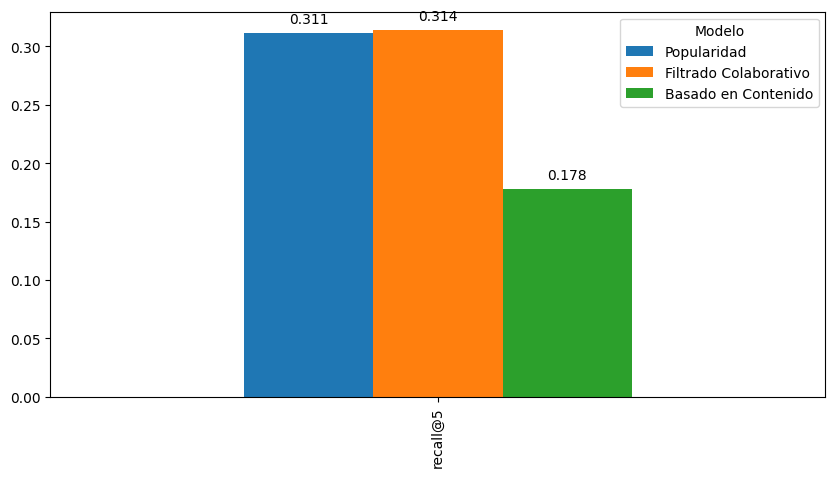

In [970]:
global_metrics_df.drop('recall@10',axis=1,inplace=True)
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(10,5))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

Probemos el mejor modelo

In [965]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = acciones_df_prueba_indexed
    else:
        interactions_df = acciones_df_entrenamiento_indexed
    return acciones_df_indexed.loc[person_id].merge(oferta_formativa_df, how = 'left', 
                                                      left_on = 'ID_OFERTA_FORMATIVA', 
                                                      right_on = 'ID') \
                          .sort_values('PUNTAJE', ascending = False)

Aqui vemos los cursos que ha interactuado

In [966]:
inspect_interactions('70321563', test_set=False).head(10)

,ID_OFERTA_FORMATIVA,PUNTAJE,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
37,232,4,232,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,ESTE CURSO VIRTUAL TIENE COMO PROPÓSITO FORTAL...,DOCENTES DE EDUCACIÓN BÁSICA REGULAR DEL NIVEL...,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
14,197,4,197,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,TODAS,PRIMARIA,EDUCACIÓN BÁSICA REGULAR
22,203,4,203,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,CIENCIAS SOCIALES,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
35,293,4,293,EDUCACIÓN FINANCIERA,EL PRESENTE CURSO AUTOFORMATIVO TIENE COMO PRO...,DOCENTES DE EDUCACIÓN BÁSICA,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
21,206,4,206,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,EDUCACIÓN PARA EL TRABAJO,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
20,200,4,200,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,CIENCIA Y TECNOLOGÍA,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
18,205,4,205,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,THIS VIRTUAL SELF-TRAINING COURSE AIMS TO STRE...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,INGLÉS,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
31,251,4,251,APLICANDO LOS PRINCIPIOS DEL DUA,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTES DE LA EDUCACIÓN BÁSICA,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
17,207,4,207,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,EL CURSO SE DESARROLLA EN LA MODALIDAD VIRTUAL...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,EDUCACIÓN RELIGIOSA,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
15,208,4,208,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,AULA DE INNOVACIÓN,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR


## Recomendaciones

In [971]:
#FiltroColaborativo= CFRecommender()
cf_recommender_model.recommend_items(user_id='70321563', topn=3, verbose=True)

,ID_OFERTA_FORMATIVA,PUN_PREDICT,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,231,0.964982,231,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,ESTE CURSO TIENE COMO PROPÓSITO FORTALECER LAS...,DOCENTES DE INSTITUCIONES EDUCATIVAS DE EDUCAC...,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA REGULAR
1,208,0.867728,208,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,AULA DE INNOVACIÓN,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
2,197,0.863551,197,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,TODAS,PRIMARIA,EDUCACIÓN BÁSICA REGULAR


# Conclusión

En este notebook, se ha comparado las principales técnicas de sistemas de recomendacion con el conjunto de datos oferta formativa interacciones y curso participantes. Se pudo observar que, para la recomendación el filtrado colaborativo obtuvo un mejor puntaje el Recall@5